<a href="https://colab.research.google.com/github/panjiarlins/smart-security-camera-project/blob/main/ML%20Team/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import necessary libraries and connect it into google drive

In [1]:
# Define all dependencies
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import copy
import cv2
from xml.etree import ElementTree
from google.colab import drive
%matplotlib inline

#### Mount the drive

In [2]:
# Mount Google Drive
drive.mount(os.path.join(os.getcwd(), 'gdrive'))

Mounted at /content/gdrive


# **Dataset Preparation**

## Download the dataset
Get the VOC dataset for the training of this model

In [3]:
# Download the dataset
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar

--2022-06-11 09:59:03--  http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1999639040 (1.9G) [application/x-tar]
Saving to: ‘VOCtrainval_11-May-2012.tar’

VOCtrainval_11-May- 100%[===================>]   1.86G  34.5MB/s    in 55s     

2022-06-11 09:59:59 (34.7 MB/s) - ‘VOCtrainval_11-May-2012.tar’ saved [1999639040/1999639040]



## Extract the dataset

In [ ]:
# Extract the dataset
!tar xvf VOCtrainval_11-May-2012.tar

## Define all configuration

VOC have around 256 classes of object, we only take 5 classes that will be commonly detected in this case for implementation which is [bicycle, bus, car, motorbike, person].

In [5]:
IMAGE_HEIGHT, IMAGE_WIDTH = 416, 416
LABELS = ['bicycle', 'bus', 'car', 'motorbike', 'person']
GRID_WIDTH, GRID_HEIGHT = 13, 13
BATCH_SIZE = 16
GROUNDTRUTH_BOX = 20
ANCHOR_BOXES = []
BOX = []

## Split the data for data train, data validation, and data test



In [6]:
# Define functions to procure annotations then save them into variable

def get_annotation(images_path, annotation_path, labels=[], validation_test_split=None):
  '''Obtaining necessary object annotations in every xml files'''
  if not labels: assert False, 'Please input your labels!'

  images= []
  for annotation in sorted(os.listdir(annotation_path)):
    if 'xml' not in annotation: continue
    image = {'object': []}
    annotation_tree = ElementTree.parse(os.path.join(annotation_path, annotation))

    for element in annotation_tree.iter():
      if 'filename' in element.tag:
        image_path = os.path.join(images_path, element.text)
        if not os.path.exists(image_path):
            assert False, f'File {image_path} is not found!'
        image['filename'] = image_path

      if 'width' in element.tag:
        image['width'] = int(element.text)

      if 'height' in element.tag:
        image['height'] = int(element.text)

      if 'object' in element.tag:
        object = {}
        for attribute in list(element):
          if 'name' in attribute.tag:
            object['name'] = attribute.text
            if object['name'] not in labels: break
            else: image['object'] += [object]

          if 'bndbox' in attribute.tag:
            for dimension in list(attribute):
              for i in ['xmin', 'ymin', 'xmax', 'ymax']:
                if i in dimension.tag:
                  object[i] = int(round(float(dimension.text)))
                  break
    if not not image['object']:
      images += [image]

  if not (validation_test_split is None):
    #test_split = int(len(images) * validation_test_split[1])
    #validation_split = int(len(images) * validation_test_split[0]) + test_split
    test_split = validation_test_split[1]
    validation_split = validation_test_split[0] + test_split
    np.random.seed(24)
    np.random.shuffle(images)
    return images[validation_split:], images[test_split:validation_split], images[:test_split]

  return images

def get_total_labels(annotations):
  '''Calculate how many times a label gets iterated'''
  total_labels = {}
  for image in annotations:
    for object in image['object']:
      if object['name'] in total_labels:
        total_labels[object['name']] += 1
      else:
        total_labels[object['name']] = 1
  return total_labels

In [7]:
images_path = os.path.join('VOCdevkit', 'VOC2012', 'JPEGImages')
annotation_path = os.path.join('VOCdevkit', 'VOC2012', 'Annotations')

# Calling the function and storing all the obtained informations
# Set the split percentages of training, validation, test data
train_images_dict, validation_images_dict, test_images_dict = get_annotation(images_path, annotation_path, labels=LABELS, validation_test_split=[800, 70])

print(f'Number of train images = {len(train_images_dict)}')
print(f'Total of train labels = {get_total_labels(train_images_dict)}')

print(f'\nNumber of validation images = {len(validation_images_dict)}')
print(f'Total of validation labels = {get_total_labels(validation_images_dict)}')

print(f'\nNumber of test images = {len(test_images_dict)}')
print(f'Total of test labels = {get_total_labels(test_images_dict)}')

Number of train images = 10000
Total of train labels = {'person': 15960, 'bus': 635, 'car': 2307, 'bicycle': 761, 'motorbike': 737}

Number of validation images = 800
Total of validation labels = {'person': 1326, 'car': 175, 'motorbike': 57, 'bicycle': 71, 'bus': 45}

Number of test images = 70
Total of test labels = {'person': 115, 'motorbike': 7, 'bus': 5, 'bicycle': 5, 'car': 10}


## Get width and height for every object then resize them with scale 0 to 1

In [8]:
def get_objects_width_height(annotations):
  object_width_height = []
  for annotation in annotations:
    img_width, img_height = float(annotation['width']), float(annotation['height'])
    for object in annotation['object']:
      object_width = (object['xmax'] - object['xmin']) / img_width
      object_height = (object['ymax'] - object['ymin']) / img_height
      object_width_height.append([object_width, object_height])
  return np.array(object_width_height)

In [9]:
# Calling the function to get width and height of every object

# TRAIN
train_objects_width_height = get_objects_width_height(train_images_dict)
print(f'Number of train objects = {train_objects_width_height.shape[0]}')
print(f'A sample train object with normalized [width, height] = {train_objects_width_height[0]}')

# VALIDATION
validation_objects_width_height = get_objects_width_height(validation_images_dict)
print(f'\nNumber of validation objects = {validation_objects_width_height.shape[0]}')
print(f'A sample validation object with normalized [width, height] = {validation_objects_width_height[0]}')

Number of train objects = 20400
A sample train object with normalized [width, height] = [0.78978979 0.998     ]

Number of validation objects = 1674
A sample validation object with normalized [width, height] = [0.374 0.92 ]


## Find Anchor Boxes

### Define the function to get the best number of anchor boxes using IOU and kmeans cluster

In [10]:
class AnchorBoxFinder:
  def __init__(self, objects_width_height, total_clusters):
    self._objects_width_height = objects_width_height
    self._total_clusters = total_clusters
    self._calculate_kmeans()
  
  def _calculate_iou(self, centroid):
    '''Calculate intersection over union'''
    centroid_area = centroid[0] * centroid[1]
    objects_area = self._objects_width_height[:, 0] * self._objects_width_height[:, 1]

    min_width = np.minimum(self._objects_width_height[:, 0], centroid[0]) 
    min_height = np.minimum(self._objects_width_height[:, 1], centroid[1])

    intersection_area = min_width * min_height
    union_area = (centroid_area + objects_area) - intersection_area

    return intersection_area / union_area
  
  def _calculate_kmeans(self):
    '''Calculate kmeans using IoU metric for the distance'''
    total_objects = self._objects_width_height.shape[0]
    distances = np.empty((total_objects, self._total_clusters))
    last_centroids_index = np.zeros((total_objects,))

    np.random.seed(42)
    centroids = self._objects_width_height[np.random.choice(total_objects, size=self._total_clusters, replace=False)]

    while True:
      for cluster_index in range(self._total_clusters):
        distances[:, cluster_index] = 1 - self._calculate_iou(centroids[cluster_index])
      
      nearest_centroids = np.argmin(distances, axis=1)
      if (last_centroids_index == nearest_centroids).all(): break

      for cluster in range(self._total_clusters):
        centroids[cluster] = np.mean(self._objects_width_height[nearest_centroids == cluster], axis=0)
      
      last_centroids_index = nearest_centroids
    
    iou_mean = 1 - np.mean(distances[np.arange(len(nearest_centroids)), nearest_centroids])

    self._centroids = centroids
    self._nearest_centroids = nearest_centroids
    self._iou_mean = iou_mean
  
  def get_centroids(self):
    return self._centroids
  
  def get_nearest_centroids(self):
    return self._nearest_centroids
  
  def get_iou_mean(self):
    return self._iou_mean
  
  def display_cluster(self):
    np.random.seed(42)
    color = [list(np.random.choice(range(255), size=3) / 255.) for _ in range(self._total_clusters)]

    for cluster_index in range(self._total_clusters):
      x = self._objects_width_height[self._nearest_centroids == cluster_index, 0]
      y = self._objects_width_height[self._nearest_centroids == cluster_index, 1]
      plt.plot(x, y, 'o', color=color[cluster_index], alpha=.1)

    plt.plot(self._centroids[:, 0], self._centroids[:, 1], 'o', color='black', alpha=1)
    plt.xlabel('objects_width')
    plt.ylabel('objects_height')
    plt.title(f'{self._total_clusters} clusters')
    plt.show()

### Visualize the width and height for all objects

Number of objects = 22074
A sample object with normalized [width, height] = [0.78978979 0.998     ]


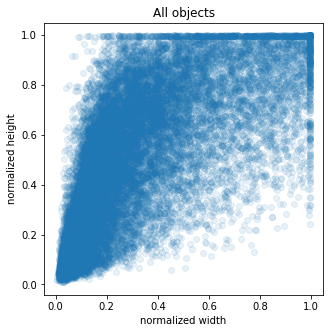

In [11]:
# Store width and height for every object
objects_width_height = get_objects_width_height(train_images_dict + validation_images_dict)
print(f'Number of objects = {objects_width_height.shape[0]}')
print(f'A sample object with normalized [width, height] = {objects_width_height[0]}')

# Display all the objects
plt.figure(figsize=(5, 5))
plt.scatter(objects_width_height[:, 0], objects_width_height[:, 1], alpha=.1)
plt.title("All objects")
plt.xlabel("normalized width")
plt.ylabel("normalized height")
plt.show()

### Visualize 2 to 10 clusters

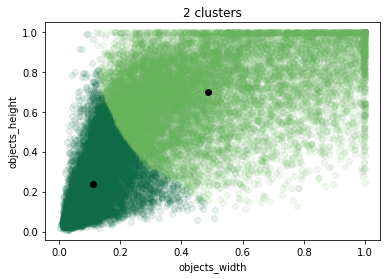

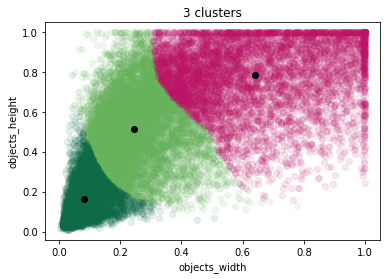

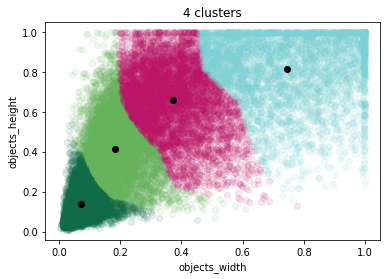

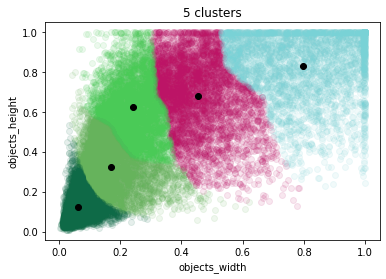

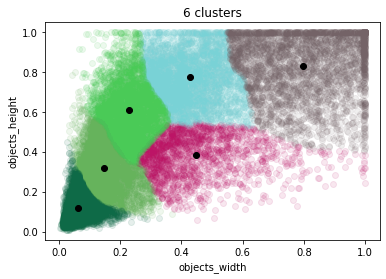

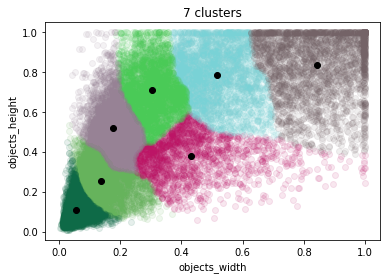

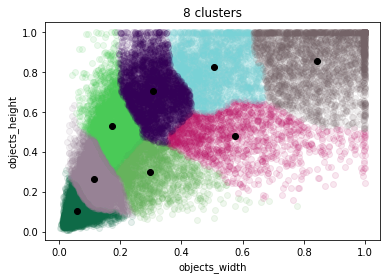

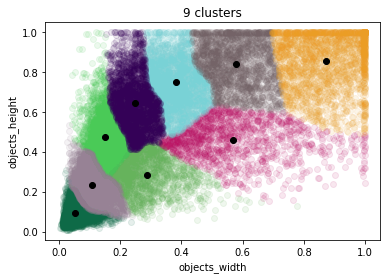

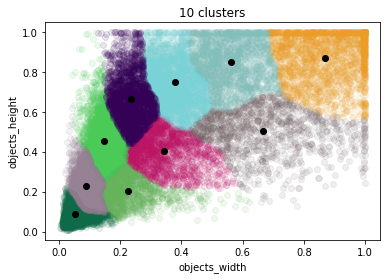

In [12]:
total_clusters = 10
results = {}
for cluster_index in range(2, total_clusters + 1):
  anchor_box_finder = AnchorBoxFinder(objects_width_height, cluster_index)
  results[cluster_index] = {'centroids': anchor_box_finder.get_centroids(),
                            'nearest_centroids': anchor_box_finder.get_nearest_centroids(),
                            'iou_mean': anchor_box_finder.get_iou_mean()}
  anchor_box_finder.display_cluster()

### Finding the best number of anchor box
Visualize the IOU mean for each cluster then determine the best number of centroids for the anchor boxes using the elbow graph

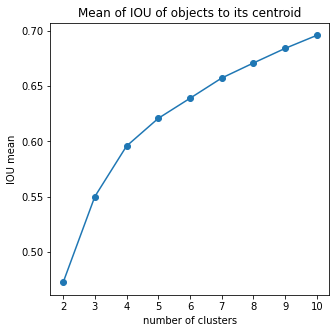

In [13]:
# Select the elbow
plt.figure(figsize=(5,5))
plt.plot(np.arange(start=2, stop=total_clusters + 1, step=1), 
         [results[cluster]['iou_mean'] for cluster in range(2, total_clusters + 1)], 'o-')
plt.title('Mean of IOU of objects to its centroid')
plt.ylabel('IOU mean')
plt.xlabel('number of clusters')
plt.show()

The best number of anchor boxes is 4 by seeing the elbow from graph above

In [14]:
# Get all the centroids of the selected cluster
ANCHOR_BOXES = results[4]['centroids'].reshape(-1)
BOX = len(ANCHOR_BOXES) // 2

print('ANCHOR BOXES:', ANCHOR_BOXES)

ANCHOR BOXES: [0.18269254 0.41441698 0.07093508 0.13790057 0.37108901 0.65870151
 0.74634487 0.81276155]


## Resize and normalize all images

In [15]:
class ReadImage:
  def __init__(self, image_height, image_width):
    self.image_height = image_height
    self.image_width = image_width
  
  def fit(self, image_dict):
    if not isinstance(image_dict, dict): image_dict = {'filename': image_dict}
    
    image = cv2.imread(image_dict['filename'])
    if image is None: print(f'file {image_dict["filename"]} is not found!')
    height, width, _ = image.shape
    image = cv2.resize(image, (self.image_height, self.image_width))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image / 255.

    if 'object' in image_dict.keys():
      objects_dict = copy.deepcopy(image_dict['object'])

      for object_dict in objects_dict:
          for attribute in ['xmin', 'xmax', 'ymin', 'ymax']:
            if attribute in ['xmin', 'xmax']:
              object_dict[attribute] = int(object_dict[attribute] * float(self.image_width) / width)
              object_dict[attribute] = max(0, min(object_dict[attribute], self.image_width))
            else:
              object_dict[attribute] = int(object_dict[attribute] * float(self.image_height) / height)
              object_dict[attribute] = max(0, min(object_dict[attribute], self.image_height))
    else:
      return image
    return image, objects_dict

### Test sample images to get the resized and normalized images and the object annotations

In [67]:
def draw_boxes_from_dict(image, objects_dict):
  color_palette = list([tuple(np.random.choice(range(255), size=3) / 255.) for i in range(8)])
  for box, color in zip(objects_dict, color_palette):
    cv2.rectangle(image,
                  pt1=(box['xmin'], box['ymin']), 
                  pt2=(box['xmax'], box['ymax']), 
                  color=color,
                  thickness=4
                  )
    cv2.putText(image,
                text=box['name'],
                org=(box['xmin']+ 12, box['ymin'] + 12),
                fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                fontScale=1e-3 * image.shape[0],
                color=(1, 0, 1),
                )
    
  return image

Before:


{'filename': 'VOCdevkit/VOC2012/JPEGImages/2011_002079.jpg',
 'height': 375,
 'object': [{'name': 'bus', 'xmax': 344, 'xmin': 1, 'ymax': 374, 'ymin': 53}],
 'width': 500}


After:


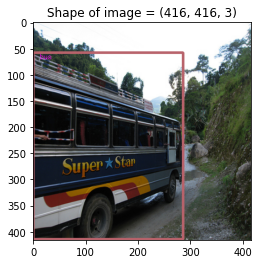

[{'name': 'bus', 'xmax': 286, 'xmin': 0, 'ymax': 414, 'ymin': 58}]

In [105]:
# TRAIN
print('Before:')
display(train_images_dict[60])

print('\nAfter:')
readImage = ReadImage(IMAGE_HEIGHT, IMAGE_WIDTH)
image, objects_dict = readImage.fit(train_images_dict[60])

image = draw_boxes_from_dict(image, objects_dict)
plt.imshow(image)
plt.title(f'Shape of image = {image.shape}')
plt.show()
display(objects_dict)

Before:


{'filename': 'VOCdevkit/VOC2012/JPEGImages/2008_005747.jpg',
 'height': 500,
 'object': [{'name': 'car', 'xmax': 369, 'xmin': 1, 'ymax': 500, 'ymin': 32}],
 'width': 375}


After:


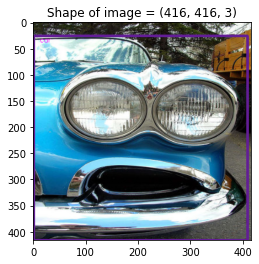

[{'name': 'car', 'xmax': 409, 'xmin': 1, 'ymax': 416, 'ymin': 26}]

In [114]:
# VALIDATION
print('Before:')
display(validation_images_dict[6])

print('\nAfter:')
readImage = ReadImage(IMAGE_HEIGHT, IMAGE_WIDTH)
image, objects_dict = readImage.fit(validation_images_dict[6])
plt.imshow(draw_boxes_from_dict(image, objects_dict))
plt.title(f'Shape of image = {image.shape}')
plt.show()
display(objects_dict)

## Define function to get the best anchor box for all objects

In [19]:
class BoundingBox:
  def __init__(self, x_min, y_min, x_max, y_max, confidence=None, labels_probability=None):
    self.x_min, self.y_min, self.x_max, self.y_max = x_min, y_min, x_max, y_max
    self.confidence = confidence
    self.set_label(labels_probability)
  
  def set_label(self, labels_probability):
    self.labels_probability = labels_probability
    self.label = np.argmax(self.labels_probability)
  
  def get_label(self):
    return self.label
  
  def get_highest_label_probability_score(self):
    return self.labels_probability[self.label]

class AnchorBoxMatching:
  def __init__(self, anchors=None):
    if not (anchors is None):
      self.anchors = [BoundingBox(0, 0, anchors[i], anchors[i + 1]) for i in range(0, len(anchors), 2)]
  
  def _calculate_intersection(self, box1, box2):
    x1_box1, x2_box1 = box1
    x1_box2, x2_box2 = box2

    if x1_box2 < x1_box1:
      if x2_box2 < x1_box1: return 0
      else: return min(x2_box1, x2_box2) - x1_box1
    else:
      if x2_box1 < x1_box2: return 0
      else: return min(x2_box1, x2_box2) - x1_box2
  
  def _calculate_box_area(self, box):
    box_width = box.x_max - box.x_min
    box_height = box.y_max - box.y_min
    return box_width * box_height
  
  def calculate_iou(self, box1, box2):
    intersection_width = self._calculate_intersection([box1.x_min, box1.x_max], [box2.x_min, box2.x_max])
    intersection_height = self._calculate_intersection([box1.y_min, box1.y_max], [box2.y_min, box2.y_max])
    intersection_area = intersection_width * intersection_height

    box1_area = self._calculate_box_area(box1)
    box2_area = self._calculate_box_area(box2)
    union_area = box1_area + box2_area - intersection_area

    return float(intersection_area) / union_area
  
  def fit(self, box_width, box_height):
    matched_anchor, max_iou = -1, -1

    for anchor_index in range(len(self.anchors)):
      iou = self.calculate_iou(BoundingBox(0, 0, box_width, box_height), self.anchors[anchor_index])
      if max_iou < iou: matched_anchor, max_iou = anchor_index, iou

    return matched_anchor, max_iou

### Test to get the best anchor box for example value=(width: 0.2 and height: 0.6)

In [20]:
# TEST
print('Anchor boxes:')
index = 0
for i in range(0, len(ANCHOR_BOXES), 2):
  print(f'\tindex={index}  width={ANCHOR_BOXES[i]}  height={ANCHOR_BOXES[i + 1]}')
  index += 1

print('\nTest class AnchorBoxMatching():')
anchor_box_matching = AnchorBoxMatching(ANCHOR_BOXES)
box_test_width, box_test_height = 0.2, 0.6
box_test_matched_anchor, box_test_iou = anchor_box_matching.fit(box_test_width, box_test_height)
print(f'\tBox: width={box_test_width} height={box_test_height}')
print(f'\tMatched AnchorBox: index={box_test_matched_anchor} iou={box_test_iou}')

Anchor boxes:
	index=0  width=0.1826925422137672  height=0.41441697626638907
	index=1  width=0.07093507577988668  height=0.13790057307749862
	index=2  width=0.3710890099560204  height=0.6587015133970981
	index=3  width=0.7463448677408963  height=0.8127615496823053

Test class AnchorBoxMatching():
	Box: width=0.2 height=0.6
	Matched AnchorBox: index=0 iou=0.6309240910887421


## Resize all object configuration into grid cell scale (0 to 13)

In [21]:
def centerxy_gridcellscale_rescaler(object_configuration, image_configuration):
  centerx = (object_configuration['xmin'] + object_configuration['xmax']) / 2.
  centery = (object_configuration['ymin'] + object_configuration['ymax']) / 2.

  rescaled_centerx = (centerx / image_configuration['IMAGE_WIDTH']) * image_configuration['GRID_WIDTH']
  rescaled_centery = (centery / image_configuration['IMAGE_HEIGHT']) * image_configuration['GRID_HEIGHT']

  return rescaled_centerx, rescaled_centery

def widthheight_gridcellscale_rescaler(object_configuration, image_configuration):
  width = float(object_configuration['xmax'] - object_configuration['xmin'])
  height = float(object_configuration['ymax'] - object_configuration['ymin'])
  
  rescaled_width = (width / image_configuration['IMAGE_WIDTH']) * image_configuration['GRID_WIDTH']
  rescaled_height = (height / image_configuration['IMAGE_HEIGHT']) * image_configuration['GRID_HEIGHT']

  return rescaled_width, rescaled_height

### Test to get the rescaled value from example data

In [22]:
# TEST
print('Test for centerxy_gridcellscale_rescaler() and widthheight_gridcellscale_rescaler():')
test_image_configuration = {'IMAGE_WIDTH': 416, 'IMAGE_HEIGHT': 416, 'GRID_WIDTH': 13, 'GRID_HEIGHT': 13}
test_object_configuration = {'xmin': 100, 'ymin': 50, 'xmax': 400, 'ymax': 300}

print('Before:')
display(test_image_configuration)
display(test_object_configuration)

test_centerx, test_centery = centerxy_gridcellscale_rescaler(test_object_configuration, test_image_configuration)
test_width, test_height = widthheight_gridcellscale_rescaler(test_object_configuration, test_image_configuration)

print('\nAfter:')
print(f'rescaled centerx={test_centerx}\t\tin range 0-{test_image_configuration["GRID_WIDTH"]}')
print(f'rescaled centery={test_centery}\t\tin range 0-{test_image_configuration["GRID_HEIGHT"]}')
print(f'rescaled width={test_width}\t\tin range 0-{test_image_configuration["GRID_WIDTH"]}')
print(f'rescaled height={test_height}\t\tin range 0-{test_image_configuration["GRID_HEIGHT"]}')

Test for centerxy_gridcellscale_rescaler() and widthheight_gridcellscale_rescaler():
Before:


{'GRID_HEIGHT': 13, 'GRID_WIDTH': 13, 'IMAGE_HEIGHT': 416, 'IMAGE_WIDTH': 416}

{'xmax': 400, 'xmin': 100, 'ymax': 300, 'ymin': 50}


After:
rescaled centerx=7.8125		in range 0-13
rescaled centery=5.46875		in range 0-13
rescaled width=9.375		in range 0-13
rescaled height=7.8125		in range 0-13


# **Modeling**

## Define class BatchGenerator that will used later as generator to train the data

In [23]:
class BatchGenerator(tf.keras.utils.Sequence):
  def __init__(self, images, image_configuration, shuffle=True):
    self.images_dict = images
    self.shuffle = shuffle
    if self.shuffle: np.random.shuffle(self.images_dict)

    self.image_configuration = image_configuration
    self.anchorBoxMatching = AnchorBoxMatching(self.image_configuration['ANCHORS'])
    self.readImage = ReadImage(self.image_configuration['IMAGE_HEIGHT'], self.image_configuration['IMAGE_WIDTH'])
  
  def __getitem__(self, batch_index, return_label_list=False):
    input_images_batch = np.zeros((self.image_configuration['BATCH_SIZE'],
                                   self.image_configuration['IMAGE_HEIGHT'],
                                   self.image_configuration['IMAGE_WIDTH'],
                                   3
                                   ))
    input_boxes_batch = np.zeros((self.image_configuration['BATCH_SIZE'], 1, 1, 1, self.image_configuration['GROUNDTRUTH_BOX'], 4))
    output_batch = np.zeros((self.image_configuration['BATCH_SIZE'],
                             self.image_configuration['GRID_HEIGHT'],
                             self.image_configuration['GRID_WIDTH'],
                             self.image_configuration['BOX'],
                             4 + 1 + len(self.image_configuration['LABELS'])
                             ))
    
    leftmost_image_in_batch = batch_index * self.image_configuration['BATCH_SIZE']
    rightmost_image_in_batch = (batch_index + 1) * self.image_configuration['BATCH_SIZE']

    if rightmost_image_in_batch > len(self.images_dict):
      rightmost_image_in_batch = len(self.images_dict)
      leftmost_image_in_batch = rightmost_image_in_batch - self.image_configuration['BATCH_SIZE']

    image_index = 0
    label_list = [] #get all label in objects for calculating accuracy
    for train_instance in self.images_dict[leftmost_image_in_batch : rightmost_image_in_batch]:
      temp = []
      for label in train_instance['object']:
        temp.append(self.image_configuration['LABELS'].index(label['name']))
      label_list.append(temp)
      image, objects_dict = self.readImage.fit(train_instance)

      groundtruth_box_index = 0
      for object_dict in objects_dict:
        if object_dict['xmax'] > object_dict['xmin'] and object_dict['ymax'] > object_dict['ymin'] and object_dict['name'] in self.image_configuration['LABELS']:
          centerx, centery = centerxy_gridcellscale_rescaler(object_dict, self.image_configuration)
          
          centerx_grid, centery_grid = int(np.floor(centerx)), int(np.floor(centery))

          if centerx_grid < self.image_configuration['GRID_WIDTH'] and centery_grid < self.image_configuration['GRID_HEIGHT']:
            label_index = self.image_configuration['LABELS'].index(object_dict['name'])
            width, height = widthheight_gridcellscale_rescaler(object_dict, self.image_configuration)
            fitted_anchor, _ = self.anchorBoxMatching.fit(width, height)

            output_batch[image_index, centery_grid, centerx_grid, fitted_anchor, 0:4] = [centerx, centery, width, height]
            output_batch[image_index, centery_grid, centerx_grid, fitted_anchor, 4  ] = 1.
            output_batch[image_index, centery_grid, centerx_grid, fitted_anchor, 5:] = 0
            output_batch[image_index, centery_grid, centerx_grid, fitted_anchor, 5 + label_index] = 1

            input_boxes_batch[image_index, 0, 0, 0, groundtruth_box_index] = [centerx, centery, width, height]

            groundtruth_box_index += 1
            groundtruth_box_index = groundtruth_box_index % int(self.image_configuration['GROUNDTRUTH_BOX'])

      input_images_batch[image_index] = image
      image_index += 1

    if return_label_list: return [input_images_batch, input_boxes_batch], output_batch, label_list
    return [input_images_batch, input_boxes_batch], output_batch
  
  def __len__(self):
    return int(np.ceil(len(self.images_dict) / float(self.image_configuration['BATCH_SIZE'])))
  
  def on_epoch_end(self):
    if self.shuffle: np.random.shuffle(self.images_dict)

## Rescale AnchorBoxes into grid cell scale

In [24]:
ANCHORS = copy.deepcopy(ANCHOR_BOXES)
ANCHORS[::2], ANCHORS[1::2] = ANCHORS[::2] * GRID_WIDTH, ANCHORS[1::2] * GRID_HEIGHT

## Define image configuration

In [25]:
image_configuration = {'LABELS' : LABELS,
                       'ANCHORS' : ANCHORS,
                       'IMAGE_HEIGHT' : IMAGE_HEIGHT,
                       'IMAGE_WIDTH' : IMAGE_WIDTH,
                       'GRID_HEIGHT' : GRID_HEIGHT,
                       'GRID_WIDTH' : GRID_WIDTH,
                       'BOX' : BOX,
                       'BATCH_SIZE' : BATCH_SIZE,
                       'GROUNDTRUTH_BOX' : GROUNDTRUTH_BOX
                       }

## Define train and validation batch generator

In [26]:
# TRAIN
train_batch_generator = BatchGenerator(train_images_dict, image_configuration)

# VALIDATION
validation_batch_generator = BatchGenerator(validation_images_dict, image_configuration, shuffle=False)

print('Get a sample batch item:\n')
[test_input_images_batch, test_input_boxes_batch], test_output_batch = train_batch_generator.__getitem__(batch_index=0)
print(f'input_images_batch.shape\t= {test_input_images_batch.shape}\t= (BATCH_SIZE, IMAGE_HEIGHT, IMAGE_WIDTH, COLOR)')
print(f'input_boxes_batch.shape\t\t= {test_input_boxes_batch.shape}\t= (BATCH_SIZE, 1, 1, 1, GROUNDTRUTH_BOX, [centerx, centery, width, height])')
print(f'output_batch.shape\t\t= {test_output_batch.shape}\t= (BATCH_SIZE, GRID_HEIGHT, GRID_WIDTH, fitted ANCHORBOX, [centerx, centery, width, height] + confidence + N labels index)')


Get a sample batch item:

input_images_batch.shape	= (16, 416, 416, 3)	= (BATCH_SIZE, IMAGE_HEIGHT, IMAGE_WIDTH, COLOR)
input_boxes_batch.shape		= (16, 1, 1, 1, 20, 4)	= (BATCH_SIZE, 1, 1, 1, GROUNDTRUTH_BOX, [centerx, centery, width, height])
output_batch.shape		= (16, 13, 13, 4, 10)	= (BATCH_SIZE, GRID_HEIGHT, GRID_WIDTH, fitted ANCHORBOX, [centerx, centery, width, height] + confidence + N labels index)


## Define all layers for the model

In [27]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Reshape, Conv2D, Input, MaxPooling2D, BatchNormalization, Lambda, LeakyReLU, concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

input_images = Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
input_boxes = Input(shape=(1, 1, 1, GROUNDTRUTH_BOX, 4))

# Layer 1
x = Conv2D(32, kernel_size=(3,3), padding='same', name='conv2d_1', use_bias=False)(input_images)
x = BatchNormalization(name='batchnormalization_1')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 2
x = Conv2D(64, kernel_size=(3,3), padding='same', name='conv2d_2', use_bias=False)(x)
x = BatchNormalization(name='batchnormalization_2')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 3
x = Conv2D(128, kernel_size=(3,3), padding='same', name='conv2d_3', use_bias=False)(x)
x = BatchNormalization(name='batchnormalization_3')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 4
x = Conv2D(64, kernel_size=(1,1), padding='same', name='conv2d_4', use_bias=False)(x)
x = BatchNormalization(name='batchnormalization_4')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 5
x = Conv2D(128, kernel_size=(3,3), padding='same', name='conv2d_5', use_bias=False)(x)
x = BatchNormalization(name='batchnormalization_5')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 6
x = Conv2D(256, kernel_size=(3,3), padding='same', name='conv2d_6', use_bias=False)(x)
x = BatchNormalization(name='batchnormalization_6')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 7
x = Conv2D(128, kernel_size=(1,1), padding='same', name='conv2d_7', use_bias=False)(x)
x = BatchNormalization(name='batchnormalization_7')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 8
x = Conv2D(256, kernel_size=(3,3), padding='same', name='conv2d_8', use_bias=False)(x)
x = BatchNormalization(name='batchnormalization_8')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 9
x = Conv2D(512, kernel_size=(3,3), padding='same', name='conv2d_9', use_bias=False)(x)
x = BatchNormalization(name='batchnormalization_9')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 10
x = Conv2D(256, kernel_size=(1,1), padding='same', name='conv2d_10', use_bias=False)(x)
x = BatchNormalization(name='batchnormalization_10')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 11
x = Conv2D(512, kernel_size=(3,3), padding='same', name='conv2d_11', use_bias=False)(x)
x = BatchNormalization(name='batchnormalization_11')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 12
x = Conv2D(256, kernel_size=(1,1), padding='same', name='conv2d_12', use_bias=False)(x)
x = BatchNormalization(name='batchnormalization_12')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 13
x = Conv2D(512, kernel_size=(3,3), padding='same', name='conv2d_13', use_bias=False)(x)
x = BatchNormalization(name='batchnormalization_13')(x)
x = LeakyReLU(alpha=0.1)(x)

skip_connection = x

x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 14
x = Conv2D(1024, kernel_size=(3,3), padding='same', name='conv2d_14', use_bias=False)(x)
x = BatchNormalization(name='batchnormalization_14')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 15
x = Conv2D(512, kernel_size=(1,1), padding='same', name='conv2d_15', use_bias=False)(x)
x = BatchNormalization(name='batchnormalization_15')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 16
x = Conv2D(1024, kernel_size=(3,3), padding='same', name='conv2d_16', use_bias=False)(x)
x = BatchNormalization(name='batchnormalization_16')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 17
x = Conv2D(512, kernel_size=(1,1), padding='same', name='conv2d_17', use_bias=False)(x)
x = BatchNormalization(name='batchnormalization_17')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 18
x = Conv2D(1024, kernel_size=(3,3), padding='same', name='conv2d_18', use_bias=False)(x)
x = BatchNormalization(name='batchnormalization_18')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 19
x = Conv2D(1024, kernel_size=(3,3), padding='same', name='conv2d_19', use_bias=False)(x)
x = BatchNormalization(name='batchnormalization_19')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 20
x = Conv2D(1024, kernel_size=(3,3), padding='same', name='conv2d_20', use_bias=False)(x)
x = BatchNormalization(name='batchnormalization_20')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 21
skip_connection = Conv2D(64, kernel_size=(1,1), padding='same', name='conv2d_21', use_bias=False)(skip_connection)
skip_connection = BatchNormalization(name='batchnormalization_21')(skip_connection)
skip_connection = LeakyReLU(alpha=0.1)(skip_connection)
skip_connection = Lambda(lambda x: tf.nn.space_to_depth(x, block_size=2))(skip_connection)

x = concatenate([skip_connection, x])

# Layer 22
x = Conv2D(1024, kernel_size=(3,3), padding='same', name='conv2d_22', use_bias=False)(x)
x = BatchNormalization(name='batchnormalization_22')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 23
x = Conv2D(512, kernel_size=(3,3), padding='same', name='conv2d_23')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 24
x = Conv2D(1024, kernel_size=(3,3), padding='same', name='conv2d_24')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 25
x = Conv2D(BOX * (4 + 1 + len(LABELS)), kernel_size=(1,1), padding='same', name='conv2d_25')(x)

output = Reshape((GRID_HEIGHT, GRID_WIDTH, BOX, 4 + 1 + len(LABELS)))(x)
output = Lambda(lambda args: args[0])([output, input_boxes])

model = Model([input_images, input_boxes], output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 416, 416, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 416, 416, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batchnormalization_1 (BatchNor  (None, 416, 416, 32  128        ['conv2d_1[0][0]']               
 malization)                    )                                                             

## Use transfer learning from yolov2 pretrained weights

### Download the weights file

In [28]:
!wget https://pjreddie.com/media/files/yolov2.weights

--2022-06-11 10:02:59--  https://pjreddie.com/media/files/yolov2.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 203934260 (194M) [application/octet-stream]
Saving to: ‘yolov2.weights’

yolov2.weights      100%[===================>] 194.49M  45.7MB/s    in 4.6s    

2022-06-11 10:03:04 (42.1 MB/s) - ‘yolov2.weights’ saved [203934260/203934260]



### Load the weights

In [29]:
class ReadWeight:
  def __init__(self, weight_path):
    self.weights = np.fromfile(weight_path, dtype=np.float32)
    self.offset = 4
      
  def get_bytes(self, weight_length):
    self.offset += weight_length
    return self.weights[self.offset - weight_length : self.offset]

  def reset(self):
    self.offset = 4

In [30]:
pretrained_weight_path = os.path.join(os.getcwd(), 'yolov2.weights')
readWeight = ReadWeight(pretrained_weight_path)
print(f'Pretrained weights.shape = {readWeight.weights.shape}')

Pretrained weights.shape = (50983565,)


### Assign the pretrained weights into first 22 layers only

In [31]:
readWeight.reset()
total_conv2d_layer = 22

for i in range(1, total_conv2d_layer + 1):
  conv2d_layer = model.get_layer(f'conv2d_{i}')

  if i < total_conv2d_layer:
    batchnormalization_layer = model.get_layer(f'batchnormalization_{i}')
    weight_length = np.prod(batchnormalization_layer.get_weights()[0].shape)

    beta = readWeight.get_bytes(weight_length)
    gamma = readWeight.get_bytes(weight_length)
    mean_moving_average = readWeight.get_bytes(weight_length)
    variance_moving_average = readWeight.get_bytes(weight_length)

    batchnormalization_layer.set_weights([gamma, beta, mean_moving_average, variance_moving_average])

  bias = readWeight.get_bytes(np.prod(conv2d_layer.get_weights()[1].shape)) if len(conv2d_layer.get_weights()) > 1 else None
  kernel = readWeight.get_bytes(np.prod(conv2d_layer.get_weights()[0].shape))
  kernel = kernel.reshape(list(reversed(conv2d_layer.get_weights()[0].shape)))
  kernel = kernel.transpose((2, 3, 1, 0))

  if bias is None: conv2d_layer.set_weights([kernel])
  else: conv2d_layer.set_weights([kernel, bias])

### Set random weights for the last 3 layers

In [32]:
for i in range(23, 26):
  kernel = np.random.normal(size=model.get_layer(f'conv2d_{i}').get_weights()[0].shape) / (GRID_HEIGHT * GRID_WIDTH)
  bias = np.random.normal(size=model.get_layer(f'conv2d_{i}').get_weights()[1].shape) / (GRID_HEIGHT * GRID_WIDTH)
  model.get_layer(f'conv2d_{i}').set_weights([kernel, bias])

## Define function for calculating accuracy

### Rescale the image output

In [33]:
class RescaleOutput:
    def __init__(self, anchors):
        self.anchors = anchors

    def fit(self, output):
        img_grid_height, img_grid_width, img_box, _ = output.shape
        anchors_width, anchors_height = self.anchors[::2], self.anchors[1::2]

        arr_img_grid_height = np.zeros_like(output[..., 0])
        arr_img_grid_width = np.zeros_like(output[..., 0])
        arr_img_anchors_width = np.zeros_like(output[..., 0])
        arr_img_anchors_height = np.zeros_like(output[..., 0])

        for i in range(img_grid_height):
            arr_img_grid_height[i, :, :] = i

        for i in range(img_grid_width):
            arr_img_grid_width[:, i, :] = i
        
        for i in range(img_box):
            arr_img_anchors_width[:, :, i] = anchors_width[i]

        for i in range(img_box):
            arr_img_anchors_height[:, :, i] = anchors_height[i]

        # rescale x, y, width, height in range 0-1
        output[..., 0] = (tf.sigmoid(output[..., 0]).numpy() + arr_img_grid_width) / img_grid_width
        output[..., 1] = (tf.sigmoid(output[..., 1]).numpy() + arr_img_grid_height) / img_grid_height
        output[..., 2] = (np.exp(output[..., 2]) * arr_img_anchors_width) / img_grid_width
        output[..., 3] = (np.exp(output[..., 3]) * arr_img_anchors_height) / img_grid_height

        # rescale confidence in range 0-1
        output[..., 4]   = tf.sigmoid(output[..., 4]).numpy()

        # rescale class probability in range 0-1
        confidence_expanded      = np.expand_dims(output[..., 4], -1)
        output[..., 5:]  = confidence_expanded * tf.nn.softmax(output[..., 5:], axis=-1).numpy()

        return output

### Get the image boxes that have probability more or equal than obj_treshold

In [34]:
def get_image_boxes(rescaled_result, obj_threshold=0.2):
    img_grid_height, img_grid_width, img_fitted_anchor, _ = rescaled_result.shape
    img_boxes = [] # List of boxes that having confidence > obj_threshold
    for row in range(img_grid_height):
        for column in range(img_grid_width):
            for i in range(img_fitted_anchor):
                labels_probability = rescaled_result[row, column, i, 5:]
                
                if np.sum(labels_probability) > 0:
                    center_x, center_y, box_width, box_height = rescaled_result[row, column, i, :4]
                    confidence = rescaled_result[row, column, i, 4]
                    box = BoundingBox(x_min=center_x - (box_width / 2),
                            y_min=center_y - (box_height / 2),
                            x_max=center_x + (box_width / 2),
                            y_max=center_y + (box_height / 2),
                            confidence=confidence,
                            labels_probability=labels_probability
                        )
                    if box.get_highest_label_probability_score() > obj_threshold: img_boxes.append(box)

    return img_boxes

### Suppress unwanted boxes that have low probability

In [35]:
def calculate_nonmax_suppression(img_boxes, iou_threshold=0.2, obj_threshold=0.2):
    total_boxes = len(img_boxes)
    total_label = len(img_boxes[0].labels_probability)
    anchorBoxMatching = AnchorBoxMatching()
    index_boxes = []
    
    # suppress non-maximal boxes
    for label_index in range(total_label):
        all_nth_label_probabilities = [img_box.labels_probability[label_index] for img_box in img_boxes]
        box_indices = list(np.argsort(all_nth_label_probabilities)[::-1])

        for i in range(total_boxes):
            ith_index_of_box_indices = box_indices[i]

            if img_boxes[ith_index_of_box_indices].labels_probability[label_index] == 0.: continue
            else:
                index_boxes.append(ith_index_of_box_indices)
                for j in range(i + 1, total_boxes):
                    jth_index_of_box_indices = box_indices[j]
                    
                    iou_i_j = anchorBoxMatching.calculate_iou(img_boxes[ith_index_of_box_indices], img_boxes[jth_index_of_box_indices])
                    if iou_i_j > iou_threshold:
                        img_boxes[jth_index_of_box_indices].labels_probability[label_index] = 0
                        img_boxes[jth_index_of_box_indices].set_label(img_boxes[jth_index_of_box_indices].labels_probability)
    
    final_img_boxes = []
    all_confidence = []
    for i in index_boxes:
        if img_boxes[i].get_highest_label_probability_score() > obj_threshold:
            if img_boxes[i].confidence not in all_confidence:
                all_confidence.append(img_boxes[i].confidence)
                final_img_boxes.append(img_boxes[i])

    return final_img_boxes

## Define custom loss function for model training

### Define function for rescaling the prediction output into grid cell scale

In [36]:
def prediction_gridcellscale_scaler(output_prediction, BATCH_SIZE, GRID_WIDTH, GRID_HEIGHT, ANCHORS):
  total_anchor = len(ANCHORS) // 2

  # Create grid cell
  grid_height_cell = tf.reshape(tf.tile(tf.range(GRID_WIDTH, dtype=tf.float32), multiples=[GRID_HEIGHT]), shape=(1, GRID_HEIGHT, GRID_WIDTH, 1, 1))
  grid_width_cell = tf.transpose(grid_height_cell, perm=(0,2,1,3,4))
  grid_cell = tf.tile(tf.concat([grid_height_cell, grid_width_cell], axis=-1), multiples=[BATCH_SIZE, 1, 1, total_anchor, 1])
  
  # Rescale centerxy and widthheight prediction into gridcellscale
  centerxy_prediction = tf.sigmoid(output_prediction[..., :2]) + grid_cell
  widthheight_prediction = tf.exp(output_prediction[..., 2:4]) * np.reshape(ANCHORS, [1, 1, 1, total_anchor, 2])

  confidence_prediction = tf.sigmoid(output_prediction[..., 4])
  label_prediction = output_prediction[..., 5:]

  return centerxy_prediction, widthheight_prediction, confidence_prediction, label_prediction

### Define function for parsing the ground truth output

In [37]:
def get_groundtruth(output_groundtruth):
  centerxy_groundtruth = output_groundtruth[..., 0:2]
  widthheight_groundtruth = output_groundtruth[..., 2:4]
  confidence_groundtruth = output_groundtruth[...,4]
  label_groundtruth = tf.argmax(output_groundtruth[..., 5:], -1)

  return centerxy_groundtruth, widthheight_groundtruth, confidence_groundtruth, label_groundtruth

### Define function for calculating centerx loss, centery loss, width loss, and height loss

In [38]:
def calculate_loss_centerxywidthheight(LAMBDA_COORD, confidence_groundtruth, centerxy_groundtruth, centerxy_prediction, widthheight_groundtruth, widthheight_prediction):
  L_obj = tf.expand_dims(tf.cast(confidence_groundtruth, dtype=tf.float32), axis=-1)
  N_L_obj = tf.reduce_sum(tf.cast(L_obj > 0.0, dtype=tf.float32))

  loss_centerxy = tf.reduce_sum(tf.square(centerxy_groundtruth - centerxy_prediction) * L_obj)
  loss_widthheight = tf.reduce_sum(tf.square(widthheight_groundtruth - widthheight_prediction) * L_obj)

  loss_centerxywidthheight = (LAMBDA_COORD / N_L_obj) * (loss_centerxy + loss_widthheight)

  return loss_centerxywidthheight

### Define function for calculating label probability loss

In [39]:
def calculate_loss_label(LAMBDA_CLASS, confidence_groundtruth, label_groundtruth, label_prediction):  
  L_obj = confidence_groundtruth
  N_L_obj = tf.reduce_sum(tf.cast(L_obj > 0.0, tf.float32))
  loss_label = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=label_groundtruth, logits=label_prediction)
  loss_label = tf.reduce_sum(loss_label * L_obj)
  loss_label = (LAMBDA_CLASS / N_L_obj) * loss_label
  
  return loss_label

### Define function for calculating IoU between groundtruth box and prediction box

In [40]:
def get_existed_object_iou(confidence_groundtruth,
                           centerxy_groundtruth, widthheight_groundtruth,
                           centerxy_prediction, widthheight_prediction):
  
  max_xy_groundtruth = centerxy_groundtruth + (widthheight_groundtruth * .5)
  min_xy_groundtruth = centerxy_groundtruth - (widthheight_groundtruth * .5)

  max_xy_prediction = centerxy_prediction + (widthheight_prediction * .5)
  min_xy_prediction = centerxy_prediction - (widthheight_prediction * .5)

  min_xy_intersection = tf.maximum(min_xy_prediction, min_xy_groundtruth)
  max_xy_intersection = tf.minimum(max_xy_prediction, max_xy_groundtruth)
  widthheight_intersection = tf.maximum(max_xy_intersection - min_xy_intersection, 0.)
  intersection_area = widthheight_intersection[..., 0] * widthheight_intersection[..., 1]

  groundtruth_area = widthheight_groundtruth[..., 0] * widthheight_groundtruth[..., 1]
  prediction_area = widthheight_prediction[..., 0] * widthheight_prediction[..., 1]
  union_area = prediction_area + groundtruth_area - intersection_area

  return (intersection_area / union_area) * confidence_groundtruth

### Define funtion for calculating confidence loss

In [41]:
def calculate_loss_confidence(LAMBDA_OBJECT, LAMBDA_NO_OBJECT, existed_object_iou, confidence_groundtruth, confidence_prediction):
  L_noobj = tf.cast(existed_object_iou < .6, tf.float32) * (1 - confidence_groundtruth)
  L_obj = confidence_groundtruth
  IOU = existed_object_iou
  N_conf = tf.reduce_sum(L_obj + L_noobj)

  loss_confidence = LAMBDA_OBJECT * L_obj * tf.square(IOU - confidence_prediction)
  loss_confidence = loss_confidence + (LAMBDA_NO_OBJECT * L_noobj * tf.square(IOU - confidence_prediction))
  loss_confidence = tf.reduce_sum(loss_confidence) / N_conf

  return loss_confidence

### Define custom loss function

In [42]:
def custom_loss(output_batch, output_prediction):
  # Custom loss configuration
  LAMBDA_NO_OBJECT = 0.5
  LAMBDA_OBJECT = 2.5
  LAMBDA_COORD = 0.5
  LAMBDA_CLASS = 0.5

  # Rescale prediction output into grid cell scale
  (centerxy_prediction, widthheight_prediction,
  confidence_prediction, label_prediction) = prediction_gridcellscale_scaler(output_prediction, BATCH_SIZE,
                                                                            GRID_WIDTH, GRID_HEIGHT, ANCHORS)
  
  # Parse ground truth output
  (centerxy_groundtruth, widthheight_groundtruth,
  confidence_groundtruth, label_groundtruth) = get_groundtruth(output_batch)

  # Calculate centerx, centery, width, height loss
  loss_centerxywidthheight = calculate_loss_centerxywidthheight(LAMBDA_COORD, confidence_groundtruth,
                                                                centerxy_groundtruth, centerxy_prediction,
                                                                widthheight_groundtruth, widthheight_prediction)
  
  # Calculate label probability loss
  loss_label = calculate_loss_label(LAMBDA_CLASS, confidence_groundtruth, label_groundtruth, label_prediction)

  # Calculate IoU between groundtruth and prediction box
  existed_object_iou = get_existed_object_iou(confidence_groundtruth,
                                              centerxy_groundtruth, widthheight_groundtruth,
                                              centerxy_prediction, widthheight_prediction)
  
  # Calculate confidence loss
  loss_confidence = calculate_loss_confidence(LAMBDA_OBJECT, LAMBDA_NO_OBJECT, existed_object_iou,
                                              confidence_groundtruth, confidence_prediction)
  
  return loss_centerxywidthheight + loss_label + loss_confidence

## Model training

### Define the callbacks and compile loss function as well as optimizer and learning rate into the model

In [49]:
class CalculateAccuracy(tf.keras.callbacks.Callback):
  def __init__(self, train_batch_generator, validation_batch_generator):
    super().__init__()
    self.train_batch_generator = train_batch_generator
    self.validation_batch_generator = validation_batch_generator
  
  def on_epoch_end(self, epoch, logs={}):
    train_batch_generator = self.train_batch_generator
    validation_batch_generator = self.validation_batch_generator
    model = self.model

    global ANCHORS
    global obj_threshold
    global iou_threshold

    [train_input_images_batch, train_input_boxes_batch], train_output_batch, train_label_list = train_batch_generator.__getitem__(batch_index=epoch, return_label_list=True)
    [validation_input_images_batch, validation_input_boxes_batch], validation_output_batch, validation_label_list = validation_batch_generator.__getitem__(batch_index=epoch, return_label_list=True)

    #Load every images in batch and then predict them
    #predict train data
    pred_train_label_list = []
    X = train_input_images_batch
    Y = np.zeros_like(train_input_boxes_batch)
    output = model.predict([X, Y])
    rescaleResult = RescaleOutput(ANCHORS)
    total_images = output.shape[0]
    for i in range(total_images):
      rescaled_result = rescaleResult.fit(output[i])
      img_boxes = get_image_boxes(rescaled_result, obj_threshold)
      if img_boxes:
        img_boxes = calculate_nonmax_suppression(img_boxes, iou_threshold, obj_threshold)
      
      pred_train_label_list.insert(i, [])
      for box in img_boxes:
        pred_train_label_list[i].append(box.label)

    #predict validation data
    pred_validation_label_list = []
    X = validation_input_images_batch
    output = model.predict([X, Y])
    for i in range(total_images):
      rescaled_result = rescaleResult.fit(output[i])
      img_boxes = get_image_boxes(rescaled_result, obj_threshold)
      if img_boxes:
        img_boxes = calculate_nonmax_suppression(img_boxes, iou_threshold, obj_threshold)

      pred_validation_label_list.insert(i, [])
      for box in img_boxes:
        pred_validation_label_list[i].append(box.label)

    # CALCULATE LABEL ACCURACY
    #calculate accuracy label for train data
    train_sum = 0
    train_N = 0
    for true_labels, pred_labels in zip(train_label_list, pred_train_label_list): #for all true labels and all prediction labels in an image
      train_N += len(true_labels) + len(pred_labels)
      for pred_label in pred_labels:
        if pred_label in true_labels:
          true_labels.remove(pred_label)
          train_sum += 2
    train_accuracy = train_sum / train_N
    logs['accuracy'] = train_accuracy

    #calculate accuracy label for validation data
    validation_sum = 0
    validation_N = 0
    for true_labels, pred_labels in zip(validation_label_list, pred_validation_label_list): #for all true labels and all prediction labels in an image
      validation_N += len(true_labels) + len(pred_labels)
      for pred_label in pred_labels:
        if pred_label in true_labels:
          true_labels.remove(pred_label)
          validation_sum += 2
    validation_accuracy = validation_sum / validation_N
    logs['val_accuracy'] = validation_accuracy

Compile the model with adam as optimizer and configure the learning rate using 5e-5 as learning rate

In [50]:
obj_threshold = 0.3
iou_threshold = 0.4

calculate_accuracy = CalculateAccuracy(train_batch_generator, validation_batch_generator)
early_stopping = EarlyStopping(monitor='loss', min_delta=1e-3, patience=4, verbose=1, mode='min')
model_checkpoint = ModelCheckpoint(filepath=os.path.join(os.getcwd(), 'gdrive', 'My Drive', 'capstone_project', f'model-groundtruthbox{GROUNDTRUTH_BOX}-anchorboxes{ANCHOR_BOXES.tolist()}.h5'),
                                   monitor='loss',
                                   verbose=1,
                                   save_best_only=True,
                                   mode='min'
                                   )

In [51]:
model.compile(loss=custom_loss, optimizer=Adam(learning_rate=5e-5))

### Train the model
The model then trained with 50 epoch

In [52]:
hist = model.fit(train_batch_generator,
                 steps_per_epoch=len(train_batch_generator),
                 epochs=50,
                 callbacks=[early_stopping, model_checkpoint, calculate_accuracy],
                 verbose=1,
                 validation_data=validation_batch_generator,
                 validation_steps=len(validation_batch_generator)
                 )

Epoch 1/50
625/625 [==============================] - ETA: 0s - loss: 0.9168
Epoch 1: loss improved from inf to 0.91682, saving model to /content/gdrive/My Drive/capstone_project/model-groundtruthbox20-anchorboxes[0.1826925422137672, 0.41441697626638907, 0.07093507577988668, 0.13790057307749862, 0.3710890099560204, 0.6587015133970981, 0.7463448677408963, 0.8127615496823053].h5
625/625 [==============================] - 258s 382ms/step - loss: 0.9168 - val_loss: 0.6468 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/50
625/625 [==============================] - ETA: 0s - loss: 0.4597
Epoch 2: loss improved from 0.91682 to 0.45975, saving model to /content/gdrive/My Drive/capstone_project/model-groundtruthbox20-anchorboxes[0.1826925422137672, 0.41441697626638907, 0.07093507577988668, 0.13790057307749862, 0.3710890099560204, 0.6587015133970981, 0.7463448677408963, 0.8127615496823053].h5
625/625 [==============================] - 257s 411ms/step - loss: 0.4597 - val_loss: 0.5246 

The training then stopped after 4 patience of epoch where the loss is not improving anymore. We save the last improved model to gdrive.

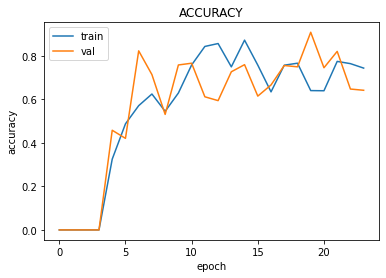

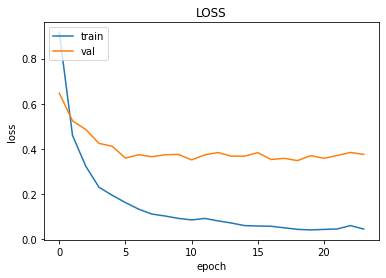

In [53]:
plt.title('ACCURACY')
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.title('LOSS')
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Model evaluation

### Load the saved model from gdrive

In [43]:
from tensorflow.keras.models import load_model
model = load_model(os.path.join(os.getcwd(), 'gdrive', 'My Drive', 'capstone_project', f'model-groundtruthbox{GROUNDTRUTH_BOX}-anchorboxes{ANCHOR_BOXES.tolist()}.h5'), compile=False)

### Define function for drawing the object boxes from model prediction output

In [48]:
def draw_boxes_from_output(image, img_boxes, labels):
  image_h, image_w, _ = image.shape
  objects_dict = []

  adjust_boxes = lambda n, nmax: max(min(nmax, n), 0)
  color_palette = list([tuple(np.random.choice(range(255), size=3) / 255.) for i in range(8)])
  for box, color in zip(img_boxes, color_palette):
    x_min = adjust_boxes(int(box.x_min * image_w), image_w)
    y_min = adjust_boxes(int(box.y_min * image_h), image_h)
    x_max = adjust_boxes(int(box.x_max * image_w), image_w)
    y_max = adjust_boxes(int(box.y_max * image_h), image_h)
    
    cv2.rectangle(image,
                  pt1=(x_min,y_min), 
                  pt2=(x_max,y_max), 
                  color=color,
                  thickness=4
                  )
    cv2.putText(img=image, 
                text=f'{labels[box.label]} {int(box.get_highest_label_probability_score() * 100)}%', 
                org=(x_min+ 12, y_min + 12),
                fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                fontScale=1e-3 * image_h,
                color=(1, 0, 1)
                )
    
    objects_dict.append({
        'name': labels[box.label],
        'xmax': x_max,
        'xmin': x_min,
        'ymax': y_max,
        'ymin': y_min,
        'confidence:': round(box.get_highest_label_probability_score(), 4)
    })
  return image, objects_dict

### Do model evaluation

In [50]:
def evaluate_model(model, images_dict, image_configuration, obj_threshold, iou_threshold):
  IMAGE_HEIGHT = image_configuration['IMAGE_HEIGHT']
  IMAGE_WIDTH = image_configuration['IMAGE_WIDTH']
  LABELS = image_configuration['LABELS']
  GROUNDTRUTH_BOX = image_configuration['GROUNDTRUTH_BOX']

  readImage = ReadImage(IMAGE_HEIGHT, IMAGE_WIDTH)
  for image_dict in images_dict:
    image, objects_dict = readImage.fit(image_dict)
    pred_objects_dict = []

    #Predict the image
    pred_labels = []
    X = np.expand_dims(image, axis=0)
    Y = np.zeros((1, 1, 1, 1, GROUNDTRUTH_BOX, 4))
    output = model.predict([X, Y])
    rescaleResult = RescaleOutput(ANCHORS)
    rescaled_result = rescaleResult.fit(output[0])
    img_boxes = get_image_boxes(rescaled_result, obj_threshold)
    if img_boxes:
      img_boxes = calculate_nonmax_suppression(img_boxes, iou_threshold, obj_threshold)
      image, pred_objects_dict = draw_boxes_from_output(X[0], img_boxes, LABELS)
    
    plt.imshow(image)
    plt.show()
    print('TRUE:', objects_dict)
    print('PRED:', pred_objects_dict)

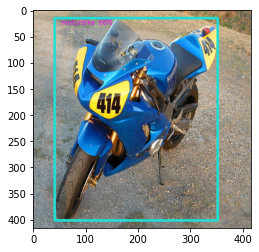

TRUE: [{'name': 'motorbike', 'xmax': 355, 'xmin': 36, 'ymax': 402, 'ymin': 15}]
PRED: [{'name': 'motorbike', 'xmax': 352, 'xmin': 41, 'ymax': 401, 'ymin': 15, 'confidence:': 0.6659}]


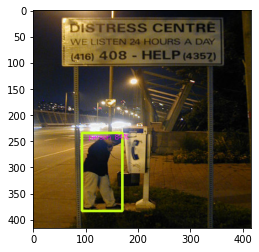

TRUE: [{'name': 'person', 'xmax': 174, 'xmin': 96, 'ymax': 386, 'ymin': 235}]
PRED: [{'name': 'person', 'xmax': 170, 'xmin': 93, 'ymax': 383, 'ymin': 234, 'confidence:': 0.8479}]


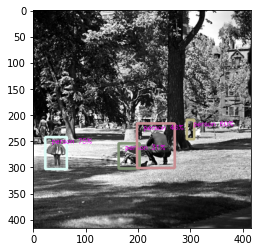

TRUE: [{'name': 'person', 'xmax': 66, 'xmin': 24, 'ymax': 303, 'ymin': 223}, {'name': 'person', 'xmax': 206, 'xmin': 164, 'ymax': 296, 'ymin': 258}]
PRED: [{'name': 'person', 'xmax': 64, 'xmin': 23, 'ymax': 303, 'ymin': 242, 'confidence:': 0.7515}, {'name': 'person', 'xmax': 203, 'xmin': 163, 'ymax': 302, 'ymin': 254, 'confidence:': 0.3143}, {'name': 'person', 'xmax': 307, 'xmin': 293, 'ymax': 246, 'ymin': 209, 'confidence:': 0.6023}, {'name': 'person', 'xmax': 270, 'xmin': 198, 'ymax': 301, 'ymin': 216, 'confidence:': 0.4617}]


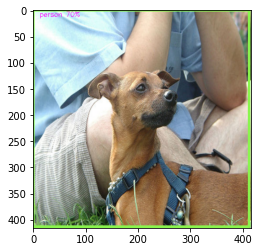

TRUE: [{'name': 'person', 'xmax': 416, 'xmin': 0, 'ymax': 416, 'ymin': 2}]
PRED: [{'name': 'person', 'xmax': 412, 'xmin': 0, 'ymax': 413, 'ymin': 0, 'confidence:': 0.7029}]


In [115]:
# Evaluate model using image from data test

evaluate_model(model, test_images_dict[44:48], image_configuration, obj_threshold=0.3, iou_threshold=0.4)